# Predicting Sales Per Share
**Brett Bartol**

In [218]:
import pandas as pd 
import numpy as np
from numpy import mean, median, arange
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import statsmodels.api as sm 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from regressors import stats

**EDA & Data Cleaning**

In [123]:
df = pd.read_csv('Assignment1Data4.csv')
df = df[df['ggroup'] == 2520]
df['SalesPerShare'] = df['revt'] / df['csho']
## dropping unneeded cols here
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'costat', 'seq', 'wcapc'])

In [124]:
df.head()

,gvkey,datadate,fyear,tic,curcd,fyr,act,at,bkvlps,capx,...,re,revt,wcap,xacc,xad,xrd,exchg,prcc_f,ggroup,SalesPerShare
299,1018,1974/06/30,1974.0,2938B,USD,6.0,1.371,4.843,1.2199,1.516,...,0.872,2.413,0.279,0.122,0.024,0.177,1.0,NaN,2520.0,1.083034
300,1018,1975/06/30,1975.0,2938B,USD,6.0,1.186,4.439,0.9329,0.341,...,0.232,1.604,-0.076,0.093,0.026,0.454,1.0,NaN,2520.0,0.722523
301,1018,1976/06/30,1976.0,2938B,USD,6.0,0.765,3.432,0.8198,0.055,...,-0.020,2.131,0.175,0.092,0.019,0.329,1.0,NaN,2520.0,0.959910
302,1018,1977/06/30,1977.0,2938B,USD,6.0,0.804,3.193,0.9099,0.144,...,0.180,2.556,0.253,0.109,0.016,0.326,1.0,NaN,2520.0,1.151351
303,1018,1978/06/30,1978.0,2938B,USD,6.0,1.361,3.541,0.8365,0.320,...,0.014,2.966,0.144,0.122,0.043,0.637,1.0,NaN,2520.0,1.332435


In [125]:
## cleaning 

# dropping csho = 0 or NaN
df = df[df['csho'] != 0]
# dropping revt = 0 or NaN
df = df[df['revt'] != 0]
df = df.dropna(subset=['revt','csho','tic'], how = 'any')
# dropping when csho < .1 bc having less 100k shares outstanding skews our findings drastically
df = df[df['csho'] > .1]


# filling NaN's with their averages
# df['act'] = df['act'].fillna(df['act'].median())
# df['lct'] = df['lct'].fillna(df['act'].median())
# df['bkvlps'] = df['bkvlps'].fillna(df['bkvlps'].median())
# df['capx'] = df['capx'].fillna(df['capx'].median())
# df['ceq'] = df['ceq'].fillna(df['ceq'].median())
# df['ch'] = df['ch'].fillna(df['ch'].median())
# df['cogs'] = df['cogs'].fillna(df['cogs'].median())
# df['dltt'] = df['dltt'].fillna(df['dltt'].median())
# df['dt'] = df['dt'].fillna(df['dt'].median())
# df['dv'] = df['dv'].fillna(df['dv'].median())
# df['ebit'] = df['ebit'].fillna(df['ebit'].median())
# df['ebitda'] = df['ebitda'].fillna(df['ebitda'].median())
# df['invt'] = df['invt'].fillna(df['invt'].median())
# df['ni'] = df['ni'].fillna(df['ni'].median())
# df['opeps'] = df['opeps'].fillna(df['opeps'].median())
# df['re'] = df['re'].fillna(df['re'].median())
# df['revt'] = df['revt'].fillna(df['revt'].median())
# #df['seq'] = df['seq'].fillna(df['seq'].median())
# df['wcap'] = df['wcap'].fillna(df['wcap'].median())
# df['xacc'] = df['xacc'].fillna(df['xacc'].median())
# df['xad'] = df['xad'].fillna(df['xad'].median())
df['xrd'] = df['xrd'].fillna(0)
#df['prcc_f'] = df['prcc_f'].fillna(df['prcc_f'].median())

df = df.reset_index(drop=True)
df

,gvkey,datadate,fyear,tic,curcd,fyr,act,at,bkvlps,capx,...,re,revt,wcap,xacc,xad,xrd,exchg,prcc_f,ggroup,SalesPerShare
0,1018,1974/06/30,1974.0,2938B,USD,6.0,1.371,4.843,1.2199,1.516,...,0.872,2.413,0.279,0.122,0.024,0.177,1.0,NaN,2520.0,1.083034
1,1018,1975/06/30,1975.0,2938B,USD,6.0,1.186,4.439,0.9329,0.341,...,0.232,1.604,-0.076,0.093,0.026,0.454,1.0,NaN,2520.0,0.722523
2,1018,1976/06/30,1976.0,2938B,USD,6.0,0.765,3.432,0.8198,0.055,...,-0.020,2.131,0.175,0.092,0.019,0.329,1.0,NaN,2520.0,0.959910
3,1018,1977/06/30,1977.0,2938B,USD,6.0,0.804,3.193,0.9099,0.144,...,0.180,2.556,0.253,0.109,0.016,0.326,1.0,NaN,2520.0,1.151351
4,1018,1978/06/30,1978.0,2938B,USD,6.0,1.361,3.541,0.8365,0.320,...,0.014,2.966,0.144,0.122,0.043,0.637,1.0,NaN,2520.0,1.332435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,271841,2016/12/31,2016.0,GFASY,USD,12.0,1045.186,1601.527,3.2577,11.016,...,-264.896,302.368,345.705,NaN,NaN,0.307,19.0,1.110,2520.0,1.661792
17003,271841,2017/12/31,2017.0,GFASY,USD,12.0,523.210,868.977,16.8342,6.178,...,-550.090,198.579,156.770,NaN,NaN,0.302,19.0,12.620,2520.0,14.654195
17004,271841,2018/12/31,2018.0,GFASY,USD,12.0,438.044,652.563,6.3801,3.232,...,-596.283,270.746,169.656,NaN,NaN,0.258,19.0,8.270,2520.0,13.610798
17005,271841,2019/12/31,2019.0,GFASY,USD,12.0,450.252,631.911,3.7477,0.891,...,-581.886,108.789,138.566,NaN,NaN,0.000,19.0,4.311,2520.0,1.859355


In [126]:
df.isna().sum()

gvkey                0
datadate             0
fyear                0
tic                  0
curcd                0
fyr                  0
act               1647
at                   0
bkvlps              97
capx               306
ceq                 10
ch                1279
cogs                 3
csho                 0
dltt                11
dt               11464
dv                 537
ebit                 3
ebitda              71
invt                58
lct               1305
ni                   3
opeps             6817
re                  87
revt                 0
wcap              1660
xacc              3120
xad               7826
xrd                  0
exchg                0
prcc_f            2009
ggroup               0
SalesPerShare        0
dtype: int64

In [127]:
# creating financial ratios
df['pm'] = df['ni'] / df['revt']
df['atr'] = df['revt'] / df['at']
df['fl'] = df['at'] / df['ceq']
df['cr'] = df['act'] / df['lct']
df['de'] = df['dt'] / df['ceq']

df['pm'] = df['pm'].fillna(df['pm'].median())
df['atr'] = df['atr'].fillna(df['atr'].median())
df['fl'] = df['fl'].fillna(df['fl'].median())
df['cr'] = df['cr'].fillna(df['cr'].median())
df['de'] = df['de'].fillna(df['de'].median())

df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [128]:
# shifting predictor variables
df['gvkey_ny'] = df['gvkey'].shift(-1)
df['rev_ny'] = df['revt'].shift(-1)
df['SalesPerShare_ny'] = df['SalesPerShare'].shift(-1)

df = df[df['gvkey'] == df['gvkey_ny']]

<ipython-input-128-3027cf31bb3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gvkey_ny'] = df['gvkey'].shift(-1)
<ipython-input-128-3027cf31bb3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rev_ny'] = df['revt'].shift(-1)
<ipython-input-128-3027cf31bb3d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

**First Models for SalesPerShare**

In [129]:
##### Do this for feature selection #####

features = ['act', 'bkvlps', 'capx', 'ceq', 'ch', 'cogs', 'dltt', 'dt', 'dv', 'ebit', 'ebitda', 'invt', 'ni', 'opeps',
       're', 'revt', 'wcap', 'xacc', 'xad', 'xrd',
       'prcc_f', 'pm', 'atr', 'fl', 'de']

X_train, X_test, y_train, y_test = train_test_split(df[features].values, df['SalesPerShare_ny'].values, test_size=0.3, random_state=42)

In [130]:
from sklearn.linear_model import LassoCV

model = LassoCV().fit(X_train, y_train)

print('\n','RMSE: ', np.sqrt(mse(y_test, model.predict(X_test))))
print('\n','R2: ', r2_score(y_test, model.predict(X_test)))

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274.75885345216375, tolerance: 127.10686499566349
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.307289336808, tolerance: 127.10686499566349
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.7075357731665, tolerance: 127.10686499566349
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.8163141416153, tolerance: 116.57642796969333
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.2622146505164, tolerance: 116.57642796969333
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499.07918471074663, tolerance: 116.57642796969333
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526


 RMSE:  19.003924251634942

 R2:  0.7082763642584353


C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.95454871002585, tolerance: 116.57642796969333
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.0004179259995, tolerance: 116.57642796969333
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1611.1294360813918, tolerance: 116.57642796969333
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:52

In [131]:
print('\n','The Features of importance: ',np.array(features)[model.coef_ != 0])

print('\n','The Features of no importance: ',np.array(features)[model.coef_ == 0])


 The Features of importance:  ['act' 'bkvlps' 'capx' 'ceq' 'ch' 'cogs' 'dltt' 'dt' 'dv' 'ebitda' 'invt'
 'ni' 're' 'revt' 'wcap' 'xacc' 'xad' 'xrd' 'prcc_f']

 The Features of no importance:  ['ebit' 'opeps' 'pm' 'atr' 'fl' 'de']


In [132]:
print('\n','Alpha: ', model.alpha_)


 Alpha:  48.793694176133165


In [133]:
for i, x in enumerate(model.coef_):
    if x != 0:
        print(features[i], x)

act 0.006749495939750109
bkvlps 0.31342411605851017
capx -0.04303373127393641
ceq -0.002404275756911696
ch 0.0037524440496986143
cogs 0.02058401768871978
dltt 0.013817273576010867
dt -0.013804323176842869
dv 0.0005887946397491255
ebitda -0.0025813880494838393
invt 0.003931934987241203
ni -0.0018137950448606551
re 0.007700229279391635
revt -0.006666457389599418
wcap -0.017147123396724875
xacc -0.01724881637987327
xad -0.005968399678545278
xrd -0.08345075580874259
prcc_f 0.366463547395158


In [134]:
stats.summary(model, X_test, y_test)

Residuals:
      Min      1Q  Median     3Q      Max
-214.4533 -6.5327  4.2636 11.327 120.4643


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept  14.077151    1.995532   7.0543  0.000000
x1           0.006749    0.002364   2.8550  0.004436
x2           0.313424    0.077473   4.0456  0.000058
x3          -0.043034    0.009919  -4.3387  0.000017
x4          -0.002404    0.001442  -1.6672  0.095936
x5           0.003752    0.003686   1.0179  0.309092
x6           0.020584    0.001842  11.1772  0.000000
x7           0.013817    0.005868   2.3545  0.018833
x8          -0.013804    0.005431  -2.5416  0.011259
x9           0.000589    0.015717   0.0375  0.970128
x10         -0.000000    0.011053  -0.0000  1.000000
x11         -0.002581    0.011211  -0.2303  0.817958
x12          0.003932    0.005355   0.7342  0.463057
x13         -0.001814    0.002461  -0.7370  0.461407
x14          0.000000    0.555069   0.0000  1.000000
x15          0.007700    0.001005   7.659

In [135]:
new = []
for i in range(len(features)):
    for j in range(i, len(features)):
        df[features[i]+features[j]] = df[features[i]] * df[features[j]]
        new.append(features[i]+features[j])

In [136]:
new_features = features + new

In [137]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[new_features].values, df['SalesPerShare_ny'].values, test_size=0.3, random_state=40)
model2 = LassoCV().fit(X_train2, y_train2)

print('\n','RMSE: ', np.sqrt(mse(y_test2, model2.predict(X_test2))))
print('\n','R2: ', r2_score(y_test2, model2.predict(X_test2)))

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428.7568203213159, tolerance: 138.6917732989982
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2053.4424646683037, tolerance: 138.6917732989982
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7412.166264676256, tolerance: 138.6917732989982
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.8026825233828, tolerance: 118.77146279261146
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.761270420393, tolerance: 118.77146279261146
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.2688220243435, tolerance: 118.77146279261146
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2045.19084931002, tolerance: 117.52406272293938
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2815.007927302271, tolerance: 117.52406272293938
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2364.8066164077027, tolerance: 117.52406272293938
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.98884179093875, tolerance: 140.3875971091221
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.9144029659219, tolerance: 140.3875971091221
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.137821670156, tolerance: 140.3875971091221
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24279.484695099643, tolerance: 140.3875971091221
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27327.727925025625, tolerance: 140.3875971091221
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28595.588910673512, tolerance: 140.3875971091221
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35777.95226958289, tolerance: 143.32205535807753
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46926.05408078595, tolerance: 143.32205535807753
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83329.45323994174, tolerance: 143.32205535807753
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:


 RMSE:  30.706291200925968

 R2:  0.006806715264820906


In [138]:
for i, x in enumerate(model2.coef_):
    if x != 0:
        print(new_features[i], x)


cogscogs 1.147503407269082e-08


In [139]:
# just financial data
features2 = ['pm', 'atr', 'fl', 'cr', 'de', 'csho', 'fyear', 're', 'revt', 'prcc_f']

X_train3, X_test3, y_train3, y_test3 = train_test_split(df[features2].values, df['SalesPerShare_ny'].values, test_size=0.3, random_state=40)
model3 = LassoCV().fit(X_train3, y_train3)

print('\n','RMSE: ', np.sqrt(mse(y_test3, model3.predict(X_test3))))
print('\n','R2: ', r2_score(y_test3, model3.predict(X_test3)))


 RMSE:  22.474599392205484

 R2:  0.4679371155791774


In [140]:
for i, x in enumerate(model3.coef_):
    if x != 0:
        print(features2[i], x)

csho -0.05988170246018866
re 0.00057882419122009
revt 0.0020858658757928676
prcc_f 0.48803426566534774


In [141]:
stats.summary(model3, X_test3, y_test3)

Residuals:
     Min      1Q  Median      3Q     Max
-178.719 -6.9413  3.9835 12.4943 82.5372


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept  17.259633  310.233133   0.0556  0.955650
x1           0.000000    0.200722   0.0000  1.000000
x2           0.000000    1.348690   0.0000  1.000000
x3           0.000000    0.116808   0.0000  1.000000
x4          -0.000000    0.390619  -0.0000  1.000000
x5           0.000000    0.238988   0.0000  1.000000
x6          -0.059882    0.006014  -9.9574  0.000000
x7           0.000000    0.000534   0.0000  1.000000
x8           0.000579    0.000465   1.2454  0.213424
x9           0.002086    0.000155  13.4831  0.000000
x10          0.488034    0.038069  12.8197  0.000000
---
R-squared:  0.46794,    Adjusted R-squared:  0.45989
F-statistic: 58.13 on 10 features


**First Models for Next Year Rev**

In [142]:
##### Do this for feature selection #####

features = [ 'act', 'bkvlps', 'capx', 'ceq', 'ch', 'cogs',
       'csho', 'dltt', 'dt', 'dv', 'ebit', 'ebitda', 'invt', 'ni', 'opeps',
       're', 'revt', 'wcap', 'xacc', 'xad', 'xrd',
       'prcc_f', 'pm', 'atr', 'fl', 'de']

X_trainr, X_testr, y_trainr, y_testr = train_test_split(df[features].values, df['rev_ny'].values, test_size=0.3, random_state=42)

In [143]:
from sklearn.linear_model import LassoCV

model_rev = LassoCV().fit(X_trainr, y_trainr)

print('\n','RMSE: ', np.sqrt(mse(y_testr, model_rev.predict(X_testr))))
print('\n','R2: ', r2_score(y_testr, model_rev.predict(X_testr)))


 RMSE:  903.5875300757222

 R2:  0.9845402776539399


In [144]:
for i, x in enumerate(model_rev.coef_):
    if x != 0:
        print(features[i], x)

act 0.6035084582016728
cogs 0.002195080176864728
revt 0.7264624908118176
wcap 0.09260295991075258


In [145]:
stats.summary(model_rev, X_testr, y_testr)

Residuals:
      Min      1Q  Median      3Q       Max
-5639.619 -7.2798 41.4846 74.8065 15121.371


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept  41.870185   97.240511   0.4306  0.666909
x1           0.603508    0.112552   5.3620  0.000000
x2          -0.000000    3.684630  -0.0000  1.000000
x3          -0.000000    0.480231  -0.0000  1.000000
x4           0.000000    0.068600   0.0000  1.000000
x5           0.000000    0.175860   0.0000  1.000000
x6           0.002195    0.088942   0.0247  0.980318
x7           0.000000    0.265051   0.0000  1.000000
x8          -0.000000    0.290562  -0.0000  1.000000
x9          -0.000000    0.269971  -0.0000  1.000000
x10         -0.000000    0.749162  -0.0000  1.000000
x11          0.000000    0.525723   0.0000  1.000000
x12         -0.000000    0.533247  -0.0000  1.000000
x13          0.000000    0.254641   0.0000  1.000000
x14          0.000000    0.117083   0.0000  1.000000
x15          0.000000   26.576285   0

In [146]:
new = []
for i in range(len(features)):
    for j in range(i, len(features)):
        df[features[i]+features[j]] = df[features[i]] * df[features[j]]
        new.append(features[i]+features[j])

In [147]:
new_features = features + new

In [148]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[new_features].values, df['rev_ny'].values, test_size=0.3, random_state=40)
model2 = LassoCV().fit(X_train2, y_train2)

print('\n','RMSE: ', np.sqrt(mse(y_test2, model2.predict(X_test2))))
print('\n','R2: ', r2_score(y_test2, model2.predict(X_test2)))

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10125678.99627304, tolerance: 9136708.694891581
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13899168.352912903, tolerance: 9136708.694891581
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9719028.793258667, tolerance: 9243074.023476835
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C


 RMSE:  2985.3721276855485

 R2:  0.7996296408770548


C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12869817.310819626, tolerance: 11023070.484712034
  model = cd_fast.enet_coordinate_descent_gram(


In [149]:
for i, x in enumerate(model2.coef_):
    if x != 0:
        print(new_features[i], x)

actrevt 3.2647214236117705e-05
ceqceq 5.08521851269822e-06
cogscogs -6.206098778420267e-06


In [150]:
features2 = ['pm', 'atr', 'fl', 'cr', 'de', 'csho', 'fyear', 're', 'revt', 'prcc_f']

X_train3, X_test3, y_train3, y_test3 = train_test_split(df[features2].values, df['rev_ny'].values, test_size=0.3, random_state=40)
model3 = LassoCV().fit(X_train3, y_train3)

print('\n','RMSE: ', np.sqrt(mse(y_test3, model3.predict(X_test3))))
print('\n','R2: ', r2_score(y_test3, model3.predict(X_test3)))


 RMSE:  656.0765817825175

 R2:  0.9903228917020196


In [151]:
for i, x in enumerate(model3.coef_):
    if x != 0:
        print(features2[i], x)

re 0.14175059229664214
revt 0.9759736203322227


**Add in Fama French Data**

In [152]:
fama = pd.read_csv('FFanual.csv')

In [153]:
data = pd.merge(df, fama, left_on = 'fyear', right_on = 'Year')
data = data.drop(labels = ['Year'], axis = 1)

In [154]:
features_ff = [ 'act', 'bkvlps', 'capx', 'ceq', 'ch', 'cogs',
       'csho', 'dltt', 'dt', 'dv', 'ebit', 'ebitda', 'invt', 'ni', 'opeps',
       're', 'revt', 'wcap', 'xacc', 'xad', 'xrd',
       'prcc_f', 'pm', 'atr', 'fl', 'de', 'Mkt-RF', 'SMB', 'HML', 'RF']

X_trainff, X_testff, y_trainff, y_testff = train_test_split(data[features_ff].values, data['SalesPerShare_ny'].values, test_size=0.3, random_state=42)

modelff = LassoCV().fit(X_trainff, y_trainff)

print('\n','RMSE: ', np.sqrt(mse(y_testff, modelff.predict(X_testff))))
print('\n','R2: ', r2_score(y_testff, modelff.predict(X_testff)))

C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.84927603055257, tolerance: 136.42627303778312
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604.6756583688548, tolerance: 136.42627303778312
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.9344389359467, tolerance: 136.42627303778312
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\barto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526


 RMSE:  19.453324245574834

 R2:  0.5483911226082823


In [155]:
print('\n','The Features of importance: ', np.array(features_ff)[modelff.coef_ != 0])

print('\n','The Features of no importance: ', np.array(features_ff)[modelff.coef_ == 0])


 The Features of importance:  ['act' 'bkvlps' 'capx' 'ceq' 'ch' 'cogs' 'csho' 'dltt' 'invt' 'ni' 're'
 'revt' 'wcap' 'xacc' 'xad' 'xrd' 'prcc_f']

 The Features of no importance:  ['dt' 'dv' 'ebit' 'ebitda' 'opeps' 'pm' 'atr' 'fl' 'de' 'Mkt-RF' 'SMB'
 'HML' 'RF']


In [156]:
stats.summary(modelff, X_testff, y_testff)

Residuals:
      Min      1Q  Median      3Q      Max
-149.1472 -9.3347  3.6833 11.0929 146.7763


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept  16.497970    2.726105   6.0518  0.000000
x1           0.003857    0.003652   1.0561  0.291286
x2           0.100036    0.102249   0.9784  0.328254
x3          -0.039158    0.017386  -2.2523  0.024624
x4          -0.002362    0.001742  -1.3560  0.175547
x5           0.004450    0.005850   0.7607  0.447124
x6           0.019987    0.002101   9.5121  0.000000
x7          -0.043760    0.006131  -7.1376  0.000000
x8           0.000472    0.005674   0.0832  0.933680
x9           0.000000    0.004386   0.0000  1.000000
x10          0.000000    0.014579   0.0000  1.000000
x11          0.000000    0.022316   0.0000  1.000000
x12         -0.000000    0.025222  -0.0000  1.000000
x13          0.012725    0.005316   2.3935  0.016962
x14         -0.001608    0.004672  -0.3442  0.730826
x15          0.000000    0.518130   0.0

**Non-Linear Model**

In [157]:
model_xgb = xgb.XGBRegressor().fit(X_trainff, y_trainff)

print('\n','RMSE: ', np.sqrt(mse(y_testff, model_xgb.predict(X_testff))))
print('\n','R2: ', r2_score(y_testff, model_xgb.predict(X_testff)))


 RMSE:  9.636457504055224

 R2:  0.8891821703736342


In [158]:
model_xgb.feature_importances_

array([0.02635099, 0.20356695, 0.05454908, 0.01409692, 0.00166333,
       0.2191464 , 0.03243903, 0.01441698, 0.00922039, 0.00862094,
       0.00187609, 0.003061  , 0.02282285, 0.00243053, 0.2594047 ,
       0.00325936, 0.00322106, 0.01140083, 0.00074683, 0.00206478,
       0.00222016, 0.01032231, 0.00906676, 0.03285596, 0.03986016,
       0.00466579, 0.00166101, 0.00285379, 0.00078054, 0.00135439],
      dtype=float32)

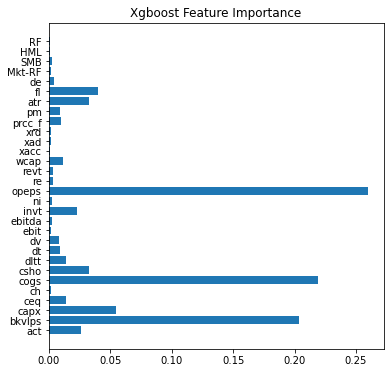

In [159]:
plt.figure(figsize = (6, 6))
plt.barh(features_ff, model_xgb.feature_importances_)
plt.title("Xgboost Feature Importance")
plt.show()

In [160]:
#important features from first LassoCV minus csho
imp_feat = ['act', 'ceq', 'bkvlps', 'ch', 'cogs', 'dltt', 'dt', 'ebit', 'invt', 're', 'revt', 'wcap', 'xacc', 'xrd', 'prcc_f']

X_trainff2, X_testff2, y_trainff2, y_testff2 = train_test_split(data[imp_feat].values, data['SalesPerShare_ny'].values, test_size=0.3, random_state=42)

model_xgb2 = xgb.XGBRegressor().fit(X_trainff2, y_trainff2)

print('\n','RMSE: ', np.sqrt(mse(y_testff2, model_xgb2.predict(X_testff2))))
print('\n','R2: ', r2_score(y_testff2, model_xgb2.predict(X_testff2)))


 RMSE:  10.006308947105177

 R2:  0.8805124560016985


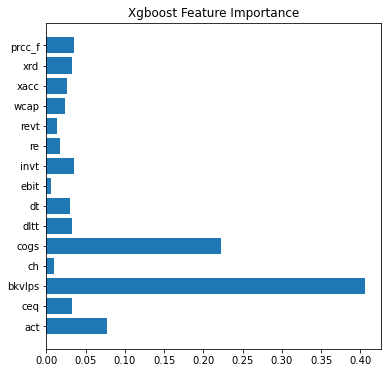

In [161]:
plt.figure(figsize=(6, 6))
plt.barh(imp_feat, model_xgb2.feature_importances_)
plt.title("Xgboost Feature Importance")
plt.show()

<AxesSubplot:>

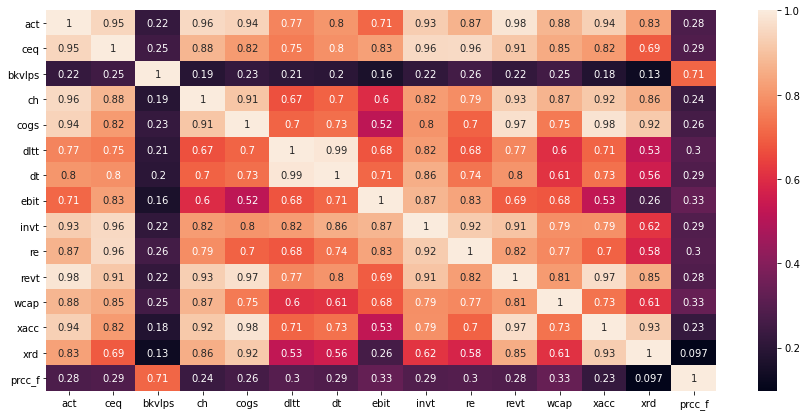

In [162]:
plt.figure(figsize=(15,7))
sns.heatmap(df[imp_feat].corr(), annot=True)

In [117]:
print('Sales per Share')
print(data.SalesPerShare_ny.describe())

Sales per Share
count    15829.000000
mean        34.690147
std         90.552621
min         -2.241471
25%          8.640371
50%         20.504702
75%         39.718124
max       6145.210526
Name: SalesPerShare_ny, dtype: float64


# New Work

In [163]:
df.head()

,gvkey,datadate,fyear,tic,curcd,fyr,act,at,bkvlps,capx,...,cshorevt,cshowcap,cshoxacc,cshoxad,cshoxrd,cshoprcc_f,cshopm,cshoatr,cshofl,cshode
52,1109,2006/12/31,2006.0,AHIXD,USD,12.0,4.249,6.750,0.7964,0.091,...,38.910384,8.716512,4.347792,2.223600,0.0,8.008622,-1.910028,5.764501,8.475162,0.051479
53,1109,2007/12/31,2007.0,AHIXD,USD,12.0,7.512,10.083,1.0064,0.067,...,33.251100,15.889665,3.237894,2.207655,0.0,5.178450,1.121476,3.297739,10.018672,0.000000
169,1278,1998/12/31,1998.0,3SOCNQ,USD,12.0,1090.968,3405.517,2.5853,53.686,...,185044.547669,49211.706673,19550.518469,12542.005500,0.0,692.580625,-49.244539,54.336698,1317.279715,874.751754
247,1468,2002/02/28,2001.0,AM.1,USD,2.0,1066.182,2614.995,14.1532,28.969,...,155375.801567,22325.404062,18959.970960,3637.501289,0.0,877.988970,-3.200286,59.417246,184.764169,60.497910
248,1468,2003/02/28,2002.0,AM.1,USD,2.0,1234.488,2584.120,16.3502,31.299,...,131525.178140,35261.961809,14203.145571,3453.041701,0.0,864.594880,3.998659,50.897473,158.047901,52.032653


In [165]:
df.shape

(2238, 392)

**LassoCV**

In [224]:
var = ['act', 'at', 'bkvlps', 'capx', 'ceq', 'ch', 'cogs', 'csho', 'dltt',
       'dt', 'dv', 'ebit', 'ebitda', 'invt', 'lct', 'ni', 'opeps', 're', 'revt',
       'wcap', 'xacc', 'xad', 'xrd', 'prcc_f', 'SalesPerShare', 'pm', 'atr', 'fl', 
       'cr', 'de']

results = []
yearly_coefs = []
for i in range(2010, 2021):
    
    train_range = range(i - 10, i)
    train_data = df[df['fyear'].isin(train_range)].copy()[var]
    train_labels = df[df['fyear'].isin(train_range)].copy()['SalesPerShare_ny']
    val_data = df[df['fyear'] == i].copy()[var]
    val_labels = df[df['fyear'] == i].copy()['SalesPerShare_ny']
    
    model_yearly = LassoCV(max_iter = 10000).fit(train_data, train_labels)
    
    print('\n', 'Year', i, 'RMSE: ', np.sqrt(mse(val_labels, model_yearly.predict(val_data))))
    print('\n', 'Year', i, 'R2: ', r2_score(val_labels, model_yearly.predict(val_data)))
    print(stats.summary(model_yearly, val_data, val_labels))
    yearly_coefs.append(model_yearly.coef_)
    results.append([i, model_yearly.predict(val_data), val_labels])


 Year 2010 RMSE:  9.611584352055807

 Year 2010 R2:  0.8994012425234467
Residuals:
     Min      1Q  Median     3Q     Max
-40.0055 -4.7761 -0.0558 2.4867 60.0034


Coefficients:
            Estimate             Std. Error         t value   p value
_intercept  3.011807   5.0491360+0.0000000j  0.5965-0.0000j  0.552163
x1          0.000000  0.003562+4853.001238j  0.0000+0.0000j  1.000000
x2          0.000582   0.0048230+0.0000000j  0.1207-0.0000j  0.904129
x3          0.000000   0.2393250+0.0000000j  0.0000+0.0000j  1.000000
x4         -0.003165   0.0850250+0.0000000j -0.0372+0.0000j  0.970377
x5         -0.001989   0.0075270+0.0000000j -0.2643+0.0000j  0.792111
x6         -0.001370   0.0137620+0.0000000j -0.0995+0.0000j  0.920899
x7          0.002564   0.0043120+0.0000000j  0.5946-0.0000j  0.553455
x8         -0.000000   0.0292280+0.0000000j  0.0000+0.0000j  1.000000
x9          0.000236   0.0235050+0.0000000j  0.0101-0.0000j  0.991997
x10         0.000000   0.0171710+0.0000000j  0.000


 Year 2014 RMSE:  9.024676443324212

 Year 2014 R2:  0.9371998400431883
Residuals:
     Min      1Q  Median     3Q     Max
-26.8594 -3.2804  0.5983 3.2696 39.0226


Coefficients:
            Estimate             Std. Error          t value   p value
_intercept  3.703040   5.0773200+0.0000000j   0.7293-0.0000j  0.467737
x1         -0.000000  0.002737+5476.307365j   0.0000+0.0000j  1.000000
x2          0.000127   0.0034070+0.0000000j   0.0371-0.0000j  0.970466
x3          0.000000   0.2147770+0.0000000j   0.0000+0.0000j  1.000000
x4         -0.000000   0.0377400+0.0000000j   0.0000+0.0000j  1.000000
x5         -0.000713   0.0059010+0.0000000j  -0.1209+0.0000j  0.904037
x6         -0.000000   0.0106470+0.0000000j   0.0000+0.0000j  1.000000
x7          0.003388   0.0026170+0.0000000j   1.2942-0.0000j  0.198971
x8         -0.002007   0.0231340+0.0000000j  -0.0868+0.0000j  0.931046
x9          0.000000   0.0209380+0.0000000j   0.0000+0.0000j  1.000000
x10        -0.000088   0.0127170+0.0000


 Year 2018 RMSE:  6.653996849233505

 Year 2018 R2:  0.9793005413165946
Residuals:
     Min      1Q  Median     3Q     Max
-28.3691 -4.0171 -0.2492 2.7803 10.1121


Coefficients:
            Estimate             Std. Error          t value   p value
_intercept  3.197359   3.4547340+0.0000000j   0.9255-0.0000j  0.357489
x1         -0.000000  5893.512876+0.000001j   0.0000+0.0000j  1.000000
x2         -0.000040   0.0031530+0.0000070j  -0.0127+0.0000j  0.989915
x3          0.000000   0.0856930+0.0000000j   0.0000+0.0000j  1.000000
x4         -0.000000   0.0344690+0.0000000j   0.0000+0.0000j  1.000000
x5         -0.000000   0.0043470+0.0000010j   0.0000+0.0000j  1.000000
x6          0.000000   0.0067070+0.0000000j   0.0000+0.0000j  1.000000
x7          0.003314   0.0023850+0.0000010j   1.3896-0.0008j  0.168492
x8         -0.002507   0.0167300+0.0000000j  -0.1498+0.0000j  0.881272
x9          0.000000   0.0204330+0.0000000j   0.0000+0.0000j  1.000000
x10        -0.000113   0.0164630+0.0000

In [202]:
true_val = np.array([])
pred_val = np.array([])
for i in range(len(results)):
    true_val = np.concatenate((true_val, results[i][2]))
    pred_val = np.concatenate((pred_val, results[i][1]))

In [203]:
print('\n', 'RMSE:', np.sqrt(mse(true_val, pred_val)))
print('\n', 'R2:', r2_score(true_val, pred_val))


 RMSE: 9.874267457825278

 R2: 0.9345674545217076


**Decision Tree**

In [209]:
from sklearn.tree import DecisionTreeRegressor
resultsdt = []
for i in range(2010, 2021):
    
    train_range = range(i - 10, i)
    train_data = df[df['fyear'].isin(train_range)].copy()[var]
    train_labels = df[df['fyear'].isin(train_range)].copy()['SalesPerShare_ny']
    val_data = df[df['fyear'] == i].copy()[var]
    val_labels = df[df['fyear'] == i].copy()['SalesPerShare_ny']
    
    dtmodel_yearly = DecisionTreeRegressor().fit(train_data, train_labels)
    
    print('\n', 'Year', i, 'RMSE: ', np.sqrt(mse(val_labels, dtmodel_yearly.predict(val_data))))
    print('\n', 'Year', i, 'R2: ', r2_score(val_labels, dtmodel_yearly.predict(val_data)))
    
    resultsdt.append([i, dtmodel_yearly.predict(val_data), val_labels])


 Year 2010 RMSE:  9.268087452189903

 Year 2010 R2:  0.9064631157271704

 Year 2011 RMSE:  7.6637731690529005

 Year 2011 R2:  0.9384741969941127

 Year 2012 RMSE:  12.001359737224915

 Year 2012 R2:  0.8669123690749764

 Year 2013 RMSE:  11.777094689042915

 Year 2013 R2:  0.8867327385024338

 Year 2014 RMSE:  12.144885409302319

 Year 2014 R2:  0.8862675716221731

 Year 2015 RMSE:  5.4101990749392606

 Year 2015 R2:  0.9797555703493556

 Year 2016 RMSE:  17.59923178590789

 Year 2016 R2:  0.823608803649585

 Year 2017 RMSE:  10.695320344777976

 Year 2017 R2:  0.9479939215965965

 Year 2018 RMSE:  10.819947583602547

 Year 2018 R2:  0.9452676468842077

 Year 2019 RMSE:  15.266287395822136

 Year 2019 R2:  0.8804877333719499

 Year 2020 RMSE:  21.11612898746778

 Year 2020 R2:  0.7667440986884199


In [210]:
true_valdt = np.array([])
pred_valdt = np.array([])
for i in range(len(results)):
    true_valdt = np.concatenate((true_valdt, resultsdt[i][2]))
    pred_valdt = np.concatenate((pred_valdt, resultsdt[i][1]))

In [211]:
print('\n', 'RMSE:', np.sqrt(mse(true_valdt, pred_valdt)))
print('\n', 'R2:', r2_score(true_valdt, pred_valdt))


 RMSE: 11.82633952766445

 R2: 0.9061390967794563


**XGBoost Model**

In [213]:
resultsxgb = []
for i in range(2010, 2021):
    
    train_range = range(i - 10, i)
    train_data = df[df['fyear'].isin(train_range)].copy()[var]
    train_labels = df[df['fyear'].isin(train_range)].copy()['SalesPerShare_ny']
    val_data = df[df['fyear'] == i].copy()[var]
    val_labels = df[df['fyear'] == i].copy()['SalesPerShare_ny']
    
    xgbmodel_yearly = xgb.XGBRegressor().fit(train_data, train_labels)
    
    print('\n', 'Year', i, 'RMSE: ', np.sqrt(mse(val_labels, xgbmodel_yearly.predict(val_data))))
    print('\n', 'Year', i, 'R2: ', r2_score(val_labels, xgbmodel_yearly.predict(val_data)))
    
    resultsxgb.append([i, xgbmodel_yearly.predict(val_data), val_labels])


 Year 2010 RMSE:  6.548191430126551

 Year 2010 R2:  0.9533076870704984

 Year 2011 RMSE:  5.856843794071419

 Year 2011 R2:  0.9640665191565182

 Year 2012 RMSE:  10.343882312221279

 Year 2012 R2:  0.9011346909841724

 Year 2013 RMSE:  7.928426289538897

 Year 2013 R2:  0.9486663609330881

 Year 2014 RMSE:  10.450810492904187

 Year 2014 R2:  0.9157834561457631

 Year 2015 RMSE:  5.2142639757786835

 Year 2015 R2:  0.9811953574746581

 Year 2016 RMSE:  13.301189872969053

 Year 2016 R2:  0.8992441039595526

 Year 2017 RMSE:  10.393904915739876

 Year 2017 R2:  0.950883886825294

 Year 2018 RMSE:  7.499742350702132

 Year 2018 R2:  0.9737041935833597

 Year 2019 RMSE:  14.404103673526226

 Year 2019 R2:  0.8936057659495245

 Year 2020 RMSE:  17.81393345738704

 Year 2020 R2:  0.8339940405455335


In [214]:
true_valxgb = np.array([])
pred_valxgb = np.array([])
for i in range(len(results)):
    true_valxgb = np.concatenate((true_valxgb, resultsxgb[i][2]))
    pred_valxgb = np.concatenate((pred_valxgb, resultsxgb[i][1]))

In [215]:
print('\n', 'RMSE:', np.sqrt(mse(true_valxgb, pred_valxgb)))
print('\n', 'R2:', r2_score(true_valxgb, pred_valxgb))


 RMSE: 9.707628838275177

 R2: 0.9367573049278918


**Portfolio from LassoCV Results**

In [256]:
current_cash = 100000
tot_at_end = []
for x, i in enumerate(range(2010, 2021)):
    curr_data = df[df['fyear'] == i]
    pred_results = curr_data[var] @ yearly_coefs[x]
    sorted_idx = np.argsort(pred_results)
    
    total_stocks = len(pred_results) - 1
    bot_stock = int(total_stocks * .75)
    
    new_tot = 0
    for j in range(bot_stock, total_stocks):
        
        df_idx = sorted_idx[sorted_idx == j].index
        df_x = list(df.index).index(df_idx)
        gvkey_id = df.iloc[df_x, :]['gvkey']
        
        beg_price = df[(df['gvkey'] == gvkey_id) & (df['fyear'] == (i - 1))]['prcc_f']
        end_price = df[(df['gvkey'] == gvkey_id) & (df['fyear'] == i)]['prcc_f']
        
        stock_return = (end_price - beg_price) / end_price
        stock_gain = current_cash / (total_stocks - bot_stock) * stock_return
        
        new_tot += stock_gain
    current_cash = new_tot
    tot_at_end.append(current_cash)

In [257]:
tot_at_end

[13628   NaN
 13629   NaN
 Name: prcc_f, dtype: float64,
 12732   NaN
 12733   NaN
 13628   NaN
 13629   NaN
 Name: prcc_f, dtype: float64,
 9540    NaN
 9541    NaN
 12732   NaN
 12733   NaN
 13628   NaN
 13629   NaN
 Name: prcc_f, dtype: float64,
 3865    NaN
 3866    NaN
 9540    NaN
 9541    NaN
 12732   NaN
 12733   NaN
 13628   NaN
 13629   NaN
 Name: prcc_f, dtype: float64,
 3865    NaN
 3866    NaN
 6061    NaN
 6062    NaN
 9540    NaN
 9541    NaN
 12732   NaN
 12733   NaN
 13628   NaN
 13629   NaN
 Name: prcc_f, dtype: float64,
 3865    NaN
 3866    NaN
 6061    NaN
 6062    NaN
 9540    NaN
 9541    NaN
 12732   NaN
 12733   NaN
 13628   NaN
 13629   NaN
 16577   NaN
 16578   NaN
 Name: prcc_f, dtype: float64,
 3865    NaN
 3866    NaN
 6061    NaN
 6062    NaN
 9540    NaN
 9541    NaN
 12732   NaN
 12733   NaN
 13113   NaN
 13114   NaN
 13628   NaN
 13629   NaN
 16577   NaN
 16578   NaN
 Name: prcc_f, dtype: float64,
 3865    NaN
 3866    NaN
 6061    NaN
 6062    NaN
 88